### Load Libraries

In [1]:
import string
import numpy as np
import PIL.Image

from os import listdir
from pickle import dump, load

from numpy import array
from numpy import argmax

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Prepare Photo Data

## VGG16 Model

### About VGG:

* Visual Geometry Group from University of Oxford developed VGG model 
* VGG model won the ImageNet competition in 2014
* Published as a conference paper at ICLR 2015: 
    https://arxiv.org/pdf/1409.1556.pdf
* Visual Geometry Group overview: http://www.robots.ox.ac.uk/~vgg/research/very_deep/


### About VGG16 Model:

* 3×3 filters in all convolutional layers
* 16 Layers Model
* Layer Configurations: https://gist.githubusercontent.com/ksimonyan/211839e770f7b538e2d8/raw/ded9363bd93ec0c770134f4e387d8aaaaa2407ce/VGG_ILSVRC_16_layers_deploy.prototxt

### Applications

* Given an image, find object name in the image.
* It can detect any one of 1000 images.
* It takes input image of size 224 * 224 * 3 (RGB image) i.e 224 * 224 pixel image with 3 channels

In [3]:
# Extract features from each photo in the directory
def extract_features(directory):
    
    # Loading the model
    model = VGG16()

    # Removing the last layer from the loaded model as we require only the features not the classification 
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # Summarizing the model 
    print(model.summary())

    # Extracting features from each photo and storing it in a dictionary 
    features = dict()

    for name in listdir(directory):

        # Defining the path of the image 
        filename = directory + '/' + name
        
        # Loading an image and converting it into size 224 * 224
        image = load_img(filename, target_size=(224, 224))
        
        # Converting the image pixels into a numpy array
        image = img_to_array(image)
        
        # Reshaping data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        
        # Preprocessing the images for the VGG model
        # The preprocess_input function is meant to adequate your image to the format the model requires.
        image = preprocess_input(image)

        # Getting features of an image
        feature = model.predict(image, verbose=0)
        
        # Getting the image name
        image_id = name.split('.')[0]

        # Storing the feature corresponding to the image in the dictionary
        features[image_id] = feature
        
        # print('>%s' % name)
        
    return features

In [5]:
# Defining the directory we are using
directory = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'

# Extracting features from all the images
features = extract_features(directory)

print('Extracted Features: ', len(features))

# Dumping the features in a pickle file for further use
dump(features, open('features.pkl', 'wb'))

553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [6]:
listdir()

['.config', 'features.pkl', 'drive', 'sample_data']

# 2. Preparing Text Data

In [7]:
# Loading the file containg all the descriptions into memory

def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')

    # Reading all text and storing it.
    text = file.read()

    # Closing the file
    file.close()
    
    return text


Function to return a dictionary of photo identifiers to the descriptions

In [8]:
def photo_to_description_mapping(descriptions):
    
    # Dictionary to store the mapping of photo identifiers to descriptions
    description_mapping = dict()
    
    # Iterating through each line of the descriptions
    for line in descriptions.split('\n'):
        
        # Splitting the lines by white space
        words = line.split()
        
        # Skipping the lines with length less than 2
        if len(line)<2:
            continue
            
        # The first word is the image_id and the rest are the part of the description of that image
        image_id, image_description = words[0], words[1:]
        
        # Retaining only the name of the image and removing the extension from it
        image_id = image_id.split('.')[0]
        
        # Image_descriptions contains comma separated words of the description, hence, converting it back to string
        image_description = ' '.join(image_description)
        
        # There are multiple descriptions per image, 
        # hence, corresponding to every image identifier in the dictionary, there is a list of description
        # if the list does not exist then we need to create it
        
        if image_id not in description_mapping:
            description_mapping[image_id] = list()
            
        # Now storing the descriptions in the mapping
        description_mapping[image_id].append(image_description)
    
    return description_mapping

Function to clean the descriptions in the following ways:
*     Convert all words to lowercase.
*    Remove all punctuation.
*     Remove all words that are one character or less in length (e.g. ‘a’).
*     Remove all words with numbers in them.

In [9]:
def clean_descriptions(description_mapping):
    
    # Preapring a translation table for removing all the punctuation
    table = str.maketrans('','', string.punctuation)
    
    # Traversing through the mapping we created
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):
            description = descriptions[i]
            description = description.split()
            
            # Converting all the words to lower case
            description = [word.lower() for word in description]
            
            # Removing the punctuation using the translation table we made
            description = [word.translate(table) for word in description]
            
            # Removing the words with length =1
            description = [word for word in description if len(word)>1]
            
            # Removing all words with number in them
            description = [word for word in description if word.isalpha()]
            
            # Converting the description back to string and overwriting in the descriptions list
            descriptions[i] = ' '.join(description)

Ideally, we want a vocabulary that is both expressive and as small as possible. A smaller vocabulary will result in a smaller model that will train faster.

For reference, we can transform the clean descriptions into a set and print its size to get an idea of the size of our dataset vocabulary.

Sets are highly optimized, don't contain any duplicate values. There implementation is based on hash table. Hence we get a vocabulary that is both expressive and small.

In [10]:
# Converting the loaded descriptions into a vocabulary of words

def to_vocabulary(descriptions):
    
    # Build a list of all description strings
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    
    return all_desc

In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [12]:
filename = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt'


# Loading descriptions
doc = load_doc(filename)

# Parsing descriptions
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))

# Cleaning the descriptions
clean_descriptions(descriptions)

# Summarizing the vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# Saving to the file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


# 3. Developing Deep Learning Model

## A.) Loading the data

In [13]:
# Function for loading a file into memory and returning text from it
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [14]:
# Function for loading a pre-defined list of photo identifiers
def load_photo_identifiers(filename):
    
    # Loading the file containing the list of photo identifier
    file = load_file(filename)
    
    # Creating a list for storing the identifiers
    photos = list()
    
    # Traversing the file one line at a time
    for line in file.split('\n'):
        if len(line) < 1:
            continue
        
        # Image name contains the extension as well but we need just the name
        identifier = line.split('.')[0]
        
        # Adding it to the list of photos
        photos.append(identifier)
        
    # Returning the set of photos created
    return set(photos)

In [15]:

# loading the cleaned descriptions that we created earlier
# we will only be loading the descriptions of the images that we will use for training
# hence we need to pass the set of train photos that the above function will be returning

def load_clean_descriptions(filename, photos):
    
    #loading the cleaned description file
    file = load_file(filename)
    
    #creating a dictionary of descripitions for storing the photo to description mapping of train images
    descriptions = dict()
    
    #traversing the file line by line
    for line in file.split('\n'):
        # splitting the line at white spaces
        words = line.split()
        
        # the first word will be the image name and the rest will be the description of that particular image
        image_id, image_description = words[0], words[1:]
        
        # we want to load only those description which corresponds to the set of photos we provided as argument
        if image_id in photos:
            #creating list of description if needed
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            #the model we will develop will generate a caption given a photo, 
            #and the caption will be generated one word at a time. 
            #The sequence of previously generated words will be provided as input. 
            #Therefore, we will need a ‘first word’ to kick-off the generation process 
            #and a ‘last word‘ to signal the end of the caption.
            #we will use 'startseq' and 'endseq' for this purpose
            #also we have to convert image description back to string
            
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions


In [16]:
# function to load the photo features created using the VGG16 model
def load_photo_features(filename, photos):
    
    #this will load the entire features
  all_features = load(open(filename, 'rb'))
    
    #we are interested in loading the features of the required photos only
  features = {k: all_features[k] for k in photos}
    
  return features

In [17]:
filename = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'

train = load_photo_identifiers(filename)
print('Dataset: ',len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000


The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the Tokenizer class that can learn this mapping from the loaded description data.

Below defines the to_lines() to convert the dictionary of descriptions into a list of strings and the create_tokenizer() function that will fit a Tokenizer given the loaded photo description text.

In [18]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Given the descriptions, fit a tokenizer

# TOKENIZER CLASS:
# This class allows to vectorize a text corpus, 
# by turning each text into either a sequence of integers 
# (each integer being the index of a token in a dictionary) 
# or, into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [19]:
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  7579


In [20]:
#calculated the length of description with most words
def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

#### We can now encode the text.
Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained.

## B.) Defining the Model

The model is in three parts:

1. **Photo Feature Extractor**: This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.

2. **Sequence Processor**: This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.

3. **Decoder**: Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.
The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.


The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.



In [21]:
#the below function loop forever with a while loop and within this, 
#loop over each image in the image directory. 
#For each image filename, we can load the image and 
#create all of the input-output sequence pairs from the image’s description.

#data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield [[input_image, input_sequence], output_word]

            
#we are calling the create_sequence() function to create 
#a batch worth of data for a single photo rather than an entire dataset. 
#This means that we must update the create_sequences() function 
#to delete the “iterate over all descriptions” for-loop.            
#Updated create sequence function for data_generator
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [22]:
from tensorflow.keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [23]:

filename = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  34
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_3[0][0]']  

In [24]:
listdir()

['.config',
 'model_2.h5',
 'model_7.h5',
 'features.pkl',
 'model.png',
 'model_9.h5',
 'model_4.h5',
 'descriptions.txt',
 'model_1.h5',
 'model_6.h5',
 'drive',
 'model_5.h5',
 'model_8.h5',
 'model_3.h5',
 'model_0.h5',
 'sample_data']

# 4. Evaluate the model

In [25]:
#this function maps an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#The function below generates a textual description given a trained model, 
#and a given prepared photo as input. It calls the function word_for_id() 
#in order to map an integer prediction back to a word.
def generate_desc(model, tokenizer, photo, max_length):
    #start tge generation process
    in_text = 'startseq'
    #iterating over the max_length since the maximum length of the description can be that only
    for i in range(max_length):
        #integer ncoding input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #padding the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        #predicting next word
        #the predict function will return probability
        prob = model.predict([photo,sequence], verbose=0)
        #converting the probability to integer
        prob = argmax(prob)
        #calling the word_for_id function in order to map integer to word
        word = word_for_id(prob, tokenizer)
        #breaking if word cannot be mapped
        if word is None:
            break
        #appending as input
        in_text += ' ' + word
        #break if end is predicted
        if word == 'endseq':
            break
    return in_text

#the below function evaluates the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [26]:
# filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
filename = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)
#max_length = max_lengthTEMP(train_descriptions)
max_length = 34
print('Description Length: ,', max_length)

# filename = '../input/flickr8k_text/Flickr_8k.testImages.txt'
filename = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_photo_identifiers(filename)
print('Dataset: ', len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=', len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=', len(test_features))

filename = 'model_7.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset:  6000
Descriptions: train= 6000
Vocabulary Size:  7579
Description Length: , 34
Dataset:  1000
Descriptions: test= 1000
Photos: test= 1000
BLEU-1:  0.47642262755316467
BLEU-2:  0.24571946090802227
BLEU-3:  0.16226754667035773
BLEU-4:  0.06744590714034837


# 5. Generate new descriptions

In [27]:
filename = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset:  6000
Descriptions: train= 6000


In [28]:
def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

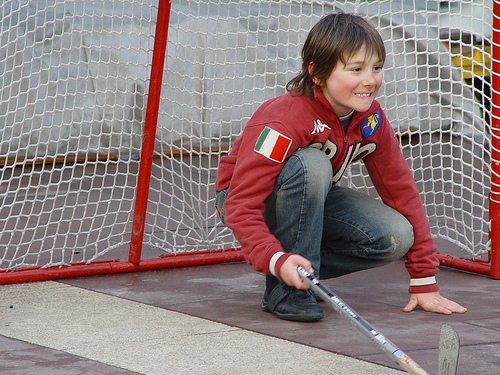

In [29]:
from IPython.display import Image
Image('/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/103106960_e8a41d64f8.jpg')


In [42]:
model = load_model('model_4.h5')
path = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/103106960_e8a41d64f8.jpg'
photo = extract_features(path)

description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

startseq young boy in pink shirt is playing in the water endseq
young boy in pink shirt is playing in the water


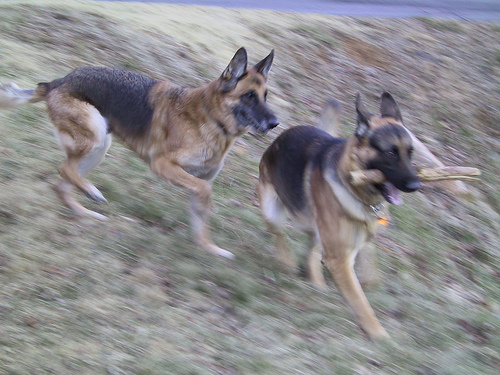

In [43]:
from IPython.display import Image
Image('/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/78984436_ad96eaa802.jpg')

In [51]:
model = load_model('model_6.h5')
path = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/78984436_ad96eaa802.jpg'
photo = extract_features(path)

description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

startseq two dogs are playing in the grass endseq
two dogs are playing in the grass


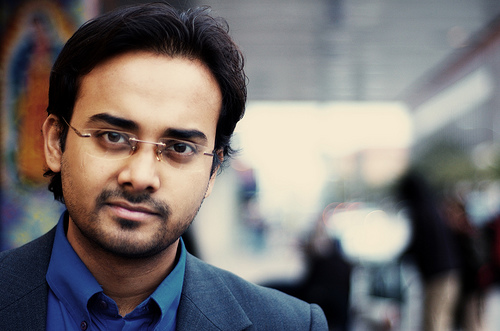

In [65]:
from IPython.display import Image
Image('/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/2385871165_9438c9fe84.jpg')

In [77]:
model = load_model('model_3.h5')
path = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/2385871165_9438c9fe84.jpg'
photo = extract_features(path)

description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

startseq man in black shirt is standing on the street endseq
man in black shirt is standing on the street


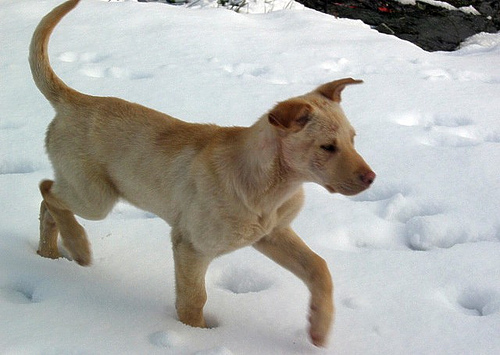

In [79]:
from IPython.display import Image
Image('/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/421808539_57abee6d55.jpg')

In [90]:
model = load_model('model_9.h5')
path = '/content/drive/MyDrive/Kaggle_dataset/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/421808539_57abee6d55.jpg'
photo = extract_features(path)

description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

startseq dog is running through the snow endseq
dog is running through the snow


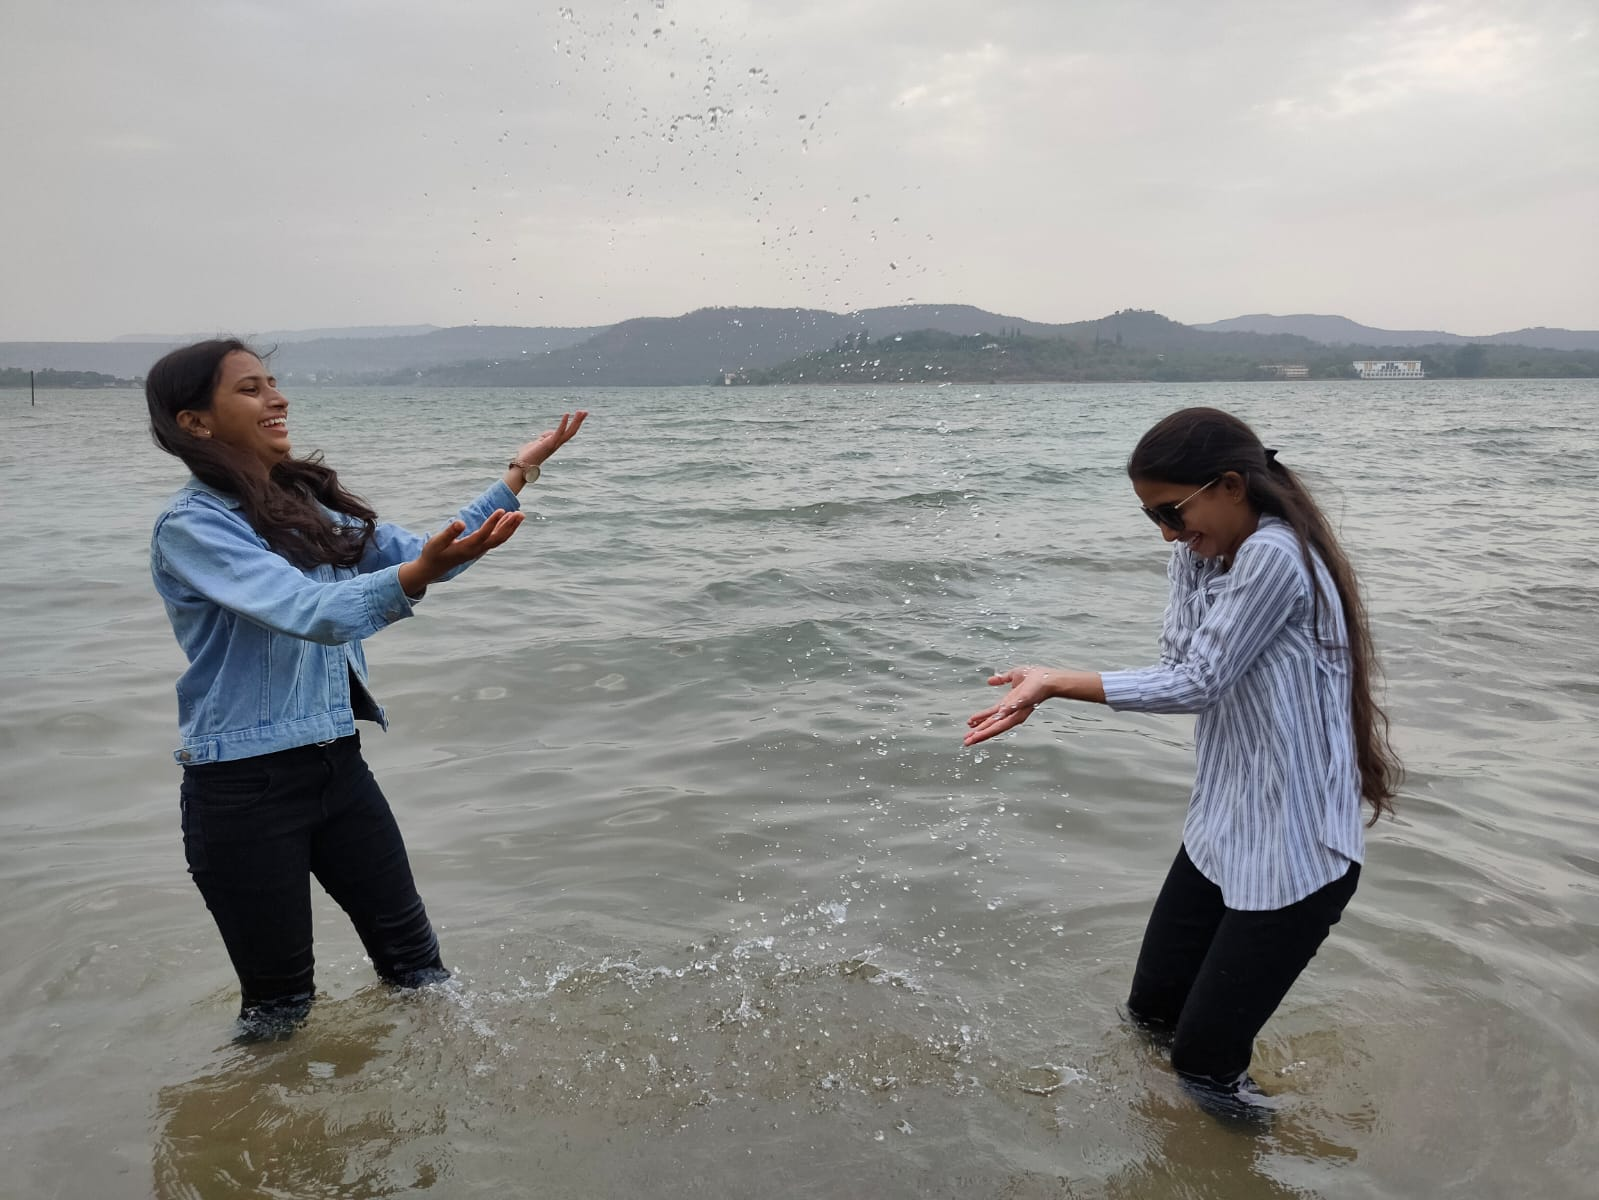

In [94]:
from IPython.display import Image
Image('/content/drive/MyDrive/test image/WhatsApp Image 2022-06-04 at 3.28.28 AM.jpeg')

In [106]:
model = load_model('model_3.h5')
path = '/content/drive/MyDrive/test image/WhatsApp Image 2022-06-04 at 3.28.28 AM.jpeg'
photo = extract_features(path)

description = generate_desc(model, tokenizer, photo, max_length)
print(description)
#Remove startseq and endseq
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

startseq two children are playing in the water endseq
two children are playing in the water
